## Objective

Make a simple Random Forests model to determine what factors affect the number of 311 issues.

In [1]:
import os, sys
sys.path.append(os.path.join(os.path.dirname('.'), "../preprocessing"))

In [2]:
from transform_for_num_issues_pred import main as transform_dataset

In [28]:
from __future__ import division
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

warnings.filterwarnings("ignore", category=DeprecationWarning)
sns.set_style("whitegrid")
sns.set_context("poster")
rcParams['figure.figsize'] = 20, 5

from helper_functions import dummify_cols_and_baselines, make_alphas

In [6]:
df_orig = pd.read_pickle('../data/data_from_remove_from_dataset.pkl')
df_orig.shape

(516406, 40)

In [7]:
df_transformed = transform_dataset(df_orig)
df_transformed.shape

../preprocessing/transform_for_num_issues_pred.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_subset['NUM_ISSUES'] = 1


(822, 221)

## Choosing columns

In [8]:
cols_orig_dataset = ['NUM_ISSUES', 'SubmittedPhoto', 'Property_Type', 'Source', 'is_description']
cols_type = [col for col in df_transformed.columns if 'TYPE' in col]
cols_census = ['race_white',
     'race_black',
     'race_asian',
     'race_hispanic',
     'race_other',
     'poverty_pop_below_poverty_level',
     'earned_income_per_capita',
     'poverty_pop_w_public_assistance',
     'poverty_pop_w_food_stamps',
     'poverty_pop_w_ssi',
     'school',
     'school_std_dev',
     'housing',
     'housing_std_dev',
     'bedroom',
     'bedroom_std_dev',
     'value',
     'value_std_dev',
     'rent',
     'rent_std_dev',
     'income',
     'income_std_dev']

In [9]:
df_col_subset = df_transformed[cols_orig_dataset + cols_type + cols_census]
df_col_subset.shape

(822, 218)

In [10]:
df = df_col_subset.dropna().drop_duplicates()
df.shape

(550, 218)

## Dummify

In [11]:
cols_to_dummify = df.dtypes[df.dtypes == object].index
cols_to_dummify

Index([u'Property_Type', u'Source', u'school', u'housing'], dtype='object')

In [12]:
df_dummified, baseline_cols = dummify_cols_and_baselines(df, cols_to_dummify)

other is baseline 0 4
Constituent Call is baseline 1 4
8_6th_grade is baseline 2 4
rent is baseline 3 4


In [13]:
df_dummified.shape

(550, 228)

## Running model

In [14]:
from sklearn.cross_validation import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import make_scorer


/home/ec2-user/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    df_dummified.drop('NUM_ISSUES', axis=1), 
    df_dummified.NUM_ISSUES, 
    test_size=0.2, 
    random_state=300
)

In [32]:
pipe = make_pipeline(RandomForestRegressor())

In [37]:
mse = make_scorer(mean_squared_error, greater_is_better=False)

In [31]:
params = {'randomforestregressor__max_depth': [5, 10, 17], 
          'randomforestregressor__n_estimators': [90, 100, 110]}
params = {'randomforestregressor__max_depth': [10], 
          'randomforestregressor__n_estimators': [100]} # best one
model = GridSearchCV(pipe, param_grid=params, n_jobs=-1, cv=5)
model.fit(X_train, y_train);

building tree 1 of 90
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
building tree 2 of 90
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
building tree 3 of 90
building tree 4 of 90
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
building tree 1 of 90
building tree 1 of 90
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
building tree 2 of 90
building tree 5 of 90
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
building tree 1 of 90
building tree 6 of 90
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
building tree 3 of 90
building tree 2 of 90
building tree 1 of 100
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.1s remaining:  

In [33]:
results = pd.DataFrame(model.cv_results_).T

In [38]:
results.head()

,0,1,2,3,4,5,6,7,8
mean_fit_time,1.39754,1.62427,1.82167,2.1693,2.34297,2.4408,2.20229,2.43943,2.57504
mean_score_time,0.175433,0.185803,0.18624,0.127199,0.162407,0.147785,0.139274,0.138215,0.14297
mean_test_score,0.502512,0.504875,0.504012,0.537466,0.542094,0.54263,0.536068,0.541328,0.541757
mean_train_score,0.87395,0.876099,0.877419,0.890546,0.892606,0.894132,0.8908,0.892883,0.89448
param_randomforestregressor__max_depth,5,5,5,10,10,10,17,17,17


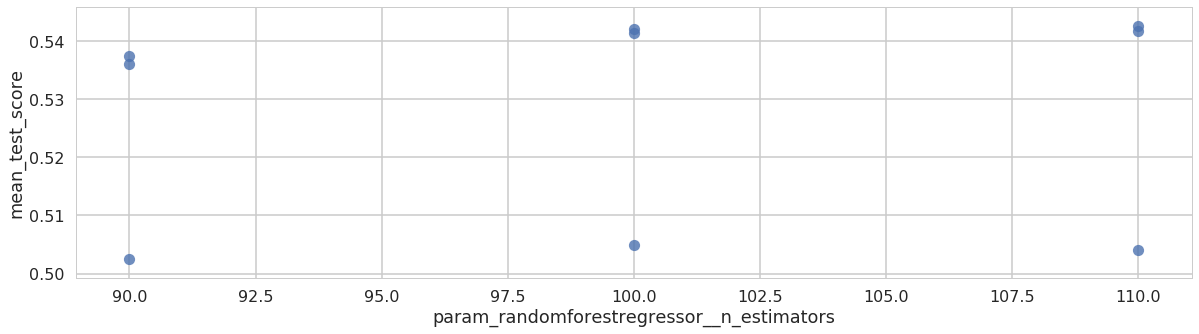

In [35]:
sns.regplot(
    x='param_randomforestregressor__n_estimators',
    y='mean_test_score',
    data=results.T[['param_randomforestregressor__n_estimators', 'mean_test_score']], 
    fit_reg=False
);

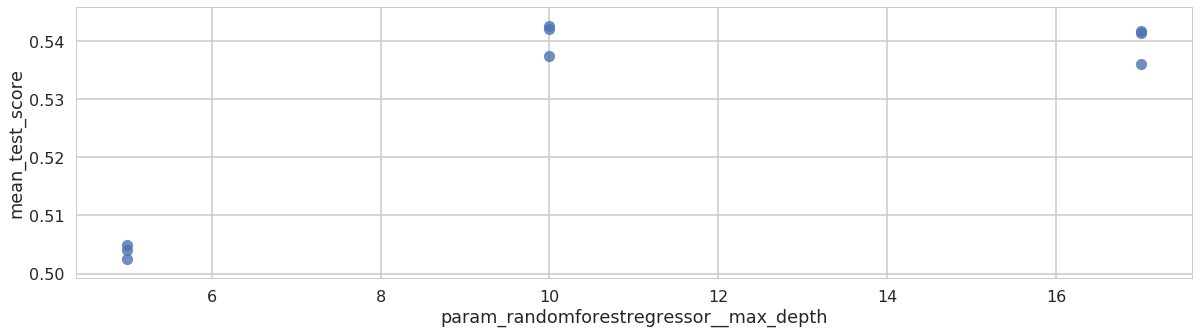

In [36]:
sns.regplot(
    x='param_randomforestregressor__max_depth',
    y='mean_test_score',
    data=results.T[['param_randomforestregressor__max_depth', 'mean_test_score']], 
    fit_reg=False
);

In [37]:
model.best_params_

{'randomforestregressor__max_depth': 10,
 'randomforestregressor__n_estimators': 110}

In [71]:
model.score(X_test, y_test)

0.55862806412569355

## Conclusion

Random Forests overfits, so our next best option is to do dimensionality reduction. Wanting to keep interpretability, I can manually do feature subset selection.